# Model B

This is a script showing results of **model B** in the ablation studies. The model is built using the following configuration:

- **Backbone:** SAGE
- **Graph type:** Homogeneous
- **Loss function:** Bayesian personalized ranking
- **Embeddings used:** average
- **Keyword popularity used:** No

*Primarily, the model is used as the STOT model from the related works using article and author contextual embeddings in training and a SAGE backbone.*

## **Setting up environment**

---



### Loading libraries

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

from torch import Tensor
from torch.nn import ModuleList
from torch.optim import Optimizer
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import SAGEConv
from torch_geometric.data import Data
from torch.optim.lr_scheduler import LRScheduler

from util.torch_geometric import get_results
from util.homogeneous.dataset import (DatasetEuCoHM, load_dataset)
from util.homogeneous.model import ModelEuCoHM
from util.homogeneous.train import (
    train,
    test,
    evaluate
)

### Global variables

In [2]:
# Model name
model_name = 'B'
# Dataset save filepath
dataset_save_filepath_prefix = '../data/dataset_homogeneous_base'
# Device name
device = 'cpu'

# Model configuration
model_config = dict(
    hidden_channels=128,
    learning_rate=1e-3,
    num_layers=4,
    num_epochs=50,
    num_recommendations=10,
    num_bootstrap=10
)
# Set seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

## Model training


---



### Model definition

In [3]:
class ModelEuCoB(ModelEuCoHM):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 num_layers: int,
                 num_recommendations: int,
                 author_node_id_map: dict,
                 author_id_map: dict,
                 device: str = 'cpu'):
        super().__init__(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            num_recommendations=num_recommendations,
            author_node_id_map=author_node_id_map,
            author_id_map=author_id_map,
            device=device
        )

        # Initialize the convolutional layers
        self.conv_layers = ModuleList([
            SAGEConv(
                in_channels=self.input_channels if ix == 0 else self.hidden_channels,
                out_channels=self.hidden_channels
            )
            for ix in range(self.num_layers)
        ])

### Training the model

In [4]:
def load_model(data: Data, model_config: dict, author_node_id_map: dict, author_id_map: dict):
    # Initialize the model
    model = ModelEuCoB(
        input_channels=data.num_features,
        hidden_channels=model_config['hidden_channels'],
        num_recommendations=model_config['num_recommendations'],
        num_layers=model_config['num_layers'],
        author_node_id_map=author_node_id_map,
        author_id_map=author_id_map
    ).to(device)
    
    # Initialize the optimizer
    optimizer: Optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=model_config['learning_rate']
    )
    
    # Initialize the scheduler
    scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.5,
        patience=10
    )
    
    return model, data, optimizer, scheduler

In [5]:
results: list = list()
for bootstrap_id in range(model_config['num_bootstrap']):
    print(f'Processing bootstrap dataset ix={bootstrap_id}...')
    dataset_filepath = f'{dataset_save_filepath_prefix}_b{bootstrap_id}.pkl'
    data, author_id_map, author_node_id_map = load_dataset(dataset_filepath=dataset_filepath, device=device)
    model, data, optimizer, scheduler = load_model(data, model_config, author_node_id_map, author_id_map)
    for epoch in range(1, model_config['num_epochs'] + 1):
        # ------ Train
        train_loss: float = train(
            model=model,
            data=data,
            optimizer=optimizer
        )
        # ------ Test
        test_loss: float = test(
            model=model,
            data=data
        )
        scheduler.step(test_loss)
        # ------ Evaluate
        evaluation_results: dict = evaluate(
            k=model_config['num_recommendations'],
            model=model,
            data=data
        )
    
        # Save results
        epoch_result = get_results(
            epoch=epoch,
            train_loss=train_loss,
            test_loss=test_loss,
            evaluation_results=evaluation_results,
            bootstrap_id=bootstrap_id,
            log_every_n_epochs=10
        )
        results.append(epoch_result)

Processing bootstrap dataset ix=0...


/home/eucollab/eutopia-colllaboration/ecr-recommender/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

Epoch 10, train loss: 0.0028, test loss: 0.2506, precision@k: 0.0356, recall@k: 0.0941, MAP@k: 0.0419, MRR@k: 0.0825, NDCG@k: 0.0678, HitRate@k: 0.1912
Epoch 20, train loss: 0.0020, test loss: 0.2235, precision@k: 0.0391, recall@k: 0.1072, MAP@k: 0.0480, MRR@k: 0.0900, NDCG@k: 0.0762, HitRate@k: 0.2079
Epoch 30, train loss: 0.0019, test loss: 0.2274, precision@k: 0.0412, recall@k: 0.1165, MAP@k: 0.0521, MRR@k: 0.0973, NDCG@k: 0.0823, HitRate@k: 0.2220
Epoch 40, train loss: 0.0018, test loss: 0.2252, precision@k: 0.0420, recall@k: 0.1194, MAP@k: 0.0529, MRR@k: 0.0985, NDCG@k: 0.0839, HitRate@k: 0.2271
Epoch 50, train loss: 0.0018, test loss: 0.2232, precision@k: 0.0421, recall@k: 0.1206, MAP@k: 0.0533, MRR@k: 0.0987, NDCG@k: 0.0845, HitRate@k: 0.2271
Processing bootstrap dataset ix=1...
Epoch 10, train loss: 0.0029, test loss: 0.2365, precision@k: 0.0319, recall@k: 0.0898, MAP@k: 0.0381, MRR@k: 0.0744, NDCG@k: 0.0627, HitRate@k: 0.1837
Epoch 20, train loss: 0.0021, test loss: 0.2394, pr

In [6]:
results

[{'Epoch': 1,
  'Train Loss': 0.0066840569488704205,
  'Test Loss': 0.17896954715251923,
  'Precision@k': 0.04199494421482086,
  'Recall@k': 0.11173642426729202,
  'MAP@k': 0.055976275354623795,
  'MRR@k': 0.10057569295167923,
  'NDCG@k': 0.08449377864599228,
  'HitRate@k': 0.21100401878356934,
  'Bootstrap ID': 0},
 {'Epoch': 2,
  'Train Loss': 0.005760937463492155,
  'Test Loss': 0.17409266531467438,
  'Precision@k': 0.04140544682741165,
  'Recall@k': 0.11217128485441208,
  'MAP@k': 0.053238190710544586,
  'MRR@k': 0.0971926674246788,
  'NDCG@k': 0.08233392983675003,
  'HitRate@k': 0.21540188789367676,
  'Bootstrap ID': 0},
 {'Epoch': 3,
  'Train Loss': 0.004296060185879469,
  'Test Loss': 0.1865067183971405,
  'Precision@k': 0.039636947214603424,
  'Recall@k': 0.10584671795368195,
  'MAP@k': 0.050868868827819824,
  'MRR@k': 0.09404921531677246,
  'NDCG@k': 0.078557588160038,
  'HitRate@k': 0.20660614967346191,
  'Bootstrap ID': 0},
 {'Epoch': 4,
  'Train Loss': 0.004560515284538269,

### Model evaluation

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'../results/results_Model_bootstrapped_{model_name}.csv', index=False)

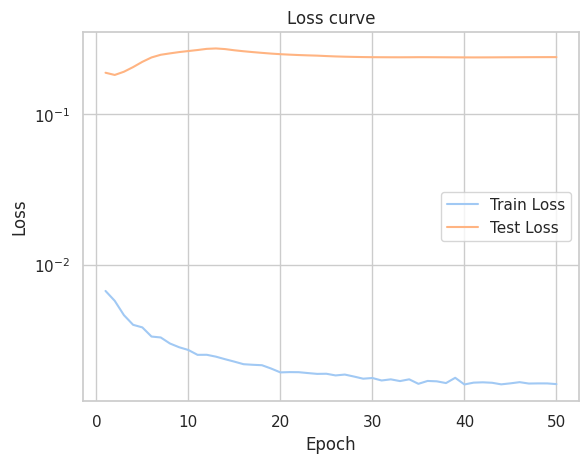

In [8]:
# Generate loss curve
# Train loss
sns.lineplot(data=results_df, x='Epoch', y='Train Loss', errorbar=None)
# Test loss
sns.lineplot(data=results_df, x='Epoch', y='Test Loss', errorbar=None)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.yscale('log')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

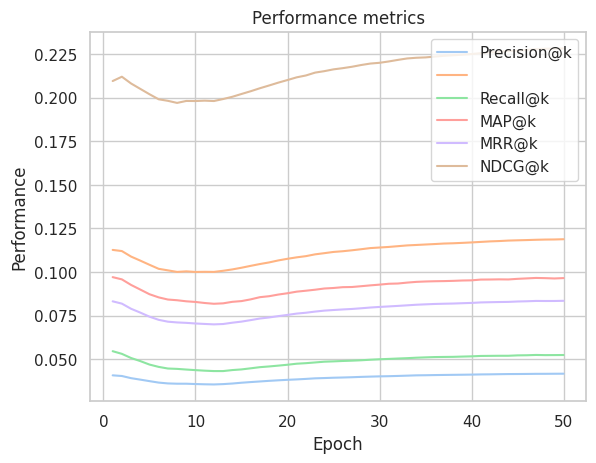

In [9]:
# Generate evaluation metrics plot
sns.lineplot(data=results_df, x='Epoch', y='Precision@k', errorbar=None)
sns.lineplot(data=results_df, x='Epoch', y='Recall@k', errorbar=None)
sns.lineplot(data=results_df, x='Epoch', y='MAP@k', errorbar=None)
sns.lineplot(data=results_df, x='Epoch', y='MRR@k', errorbar=None)
sns.lineplot(data=results_df, x='Epoch', y='NDCG@k', errorbar=None)
sns.lineplot(data=results_df, x='Epoch', y='HitRate@k', errorbar=None)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Performance metrics')
plt.legend(['Precision@k', None, 'Recall@k', 'MAP@k', 'MRR@k', 'NDCG@k', 'HitRate@k'])
plt.show()
